In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.model_selection import train_test_split

### Relevant features
Review **prob_bad** function to count correctly NaN

(Relevance 1: good 3: bad)

- (1) VehicleYear == VehicleAge\*
- (1) VehOdo: check correlation with the VehicleAge
- (1) VNST: check inside ZIP codes how it behaves
- (1) Size: SUV are bad, sports shame on you
- (2) Make: check the best ones and the worst ones
- (2) Auction = 'ADESA'
- (?) WarrantyCost: continuous


Not used for now:
- (1) TopThreeAmericanName: group of Make
- (2) PurchDate: check year and month
- (2) PRIMEUNIT: if filled seems better
- (2) AUCGUART: GREEN is good
- (2) Model: try to combine maker and model (probability)
- (2) Trim: Same as model
- (2) WheelTypeID == WheelType\* : 'Special' seems slightly bad
- (2) VNZIP1 in combination with VNST
- (3) SubModel: same as model
- (-) Color: no relevance
- (3) Transmission: Manual is slighly better
- (-) Nationality: Country of the Make, check if 1-1
- (?) MMR : continuous data
- (?) BYRNO: goes hand in hand with Auction?
- (?) VehBCost: continuous
- (3) IsOnlineSale: online is sliiiiigghtly better

In [2]:
data = pd.read_csv('training.csv')

In [3]:
# Choose the features
all_features = ['IsBadBuy', 'Auction', 'VehicleAge', 'Make', 'VehOdo', 'Size', 'VNST', 'WarrantyCost',
                'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
                'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
                'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice']
# Copy only the columns I want
features = data.loc[:, all_features]
# Erase for missing values
print('Before dropped, length = {}'.format(len(features)))
features.dropna(inplace=True)
print('After dropped, length = {}'.format(len(features)))
# Clean target from features
target = features['IsBadBuy']
features.drop('IsBadBuy', axis=1, inplace=True)

Before dropped, length = 72983
After dropped, length = 72667


In [4]:
categorical_features = ['Auction', 'VehicleAge', 'Make', 'Size', 'VNST']
encoded_features = pd.get_dummies(features, columns=categorical_features)

In [5]:
Xtrain, Xtest, ytrain, ytest = train_test_split(encoded_features, target, test_size=0.2, random_state=1)

In [6]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes=['Good', 'Bad'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### NN without scaling

In [7]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(10, ), random_state=1)
clf.fit(Xtrain, ytrain)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

Accuracy = 0.8785606164854823
Confusion matrix, without normalization
[[12767     0]
 [ 1765     2]]


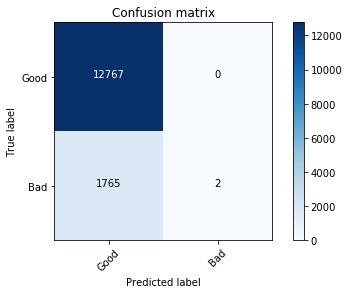

In [8]:
y_pred = clf.predict(Xtest)
print('Accuracy = {}'.format(clf.score(Xtest, ytest)))
cm = confusion_matrix(ytest, y_pred)
plot_confusion_matrix(cm)

### StandardScaler

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain1 = scaler.transform(Xtrain)
Xtest1 = scaler.transform(Xtest)

clf1 = MLPClassifier(hidden_layer_sizes=(10, ), random_state=1)
clf1.fit(Xtrain1, ytrain)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

Accuracy = 0.8785606164854823
Confusion matrix, without normalization
[[12743    24]
 [ 1741    26]]


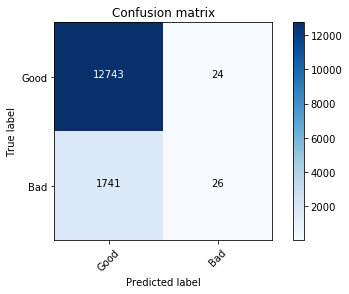

In [10]:
y_pred = clf1.predict(Xtest1)
print('Accuracy = {}'.format(clf1.score(Xtest1, ytest)))
cm = confusion_matrix(ytest, y_pred)
plot_confusion_matrix(cm)

### Unbiased input

In [11]:
# Define unbiased batches
def split_bias(X, y, test_size=0.2):
    sample_size = y.sum()
    idx_bad = (y == 1)
    X['IsBadBuy'] = y
    # Bad cars
    Xbad = X[idx_bad].sample(sample_size)
    # Good cars
    Xgood = X[~idx_bad].sample(sample_size)
    X = Xbad.append(Xgood)
    y = X['IsBadBuy']
    X = X.drop('IsBadBuy', 1)

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=1)
    return Xtrain, Xtest, ytrain, ytest

In [12]:
Xtrain, Xtest, ytrain, ytest = split_bias(encoded_features, target)
(len(Xtrain) + len(Xtest))/2
Xtrain.shape

(14310, 105)

In [29]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain1 = scaler.transform(Xtrain)
Xtest1 = scaler.transform(Xtest)

clf2 = MLPClassifier(hidden_layer_sizes=(10,), tol=0.0000001, random_state=0)
clf2.fit(Xtrain1, ytrain)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=1e-07, validation_fraction=0.1, verbose=False,
       warm_start=False)

Accuracy = 0.6678546470999301
Confusion matrix, without normalization
[[4734 2404]
 [2349 4823]]


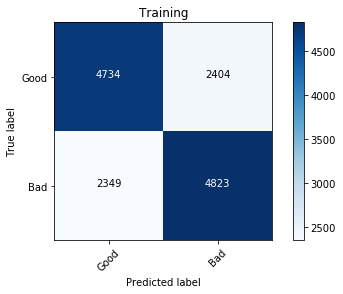

In [32]:
# Training
y_pred = clf2.predict(Xtrain1)
print('Accuracy = {}'.format(clf2.score(Xtrain1, ytrain)))
cm = confusion_matrix(ytrain, y_pred)
plot_confusion_matrix(cm, title='Training')

Accuracy = 0.6134712129681387
Confusion matrix, without normalization
[[1080  726]
 [ 657 1115]]


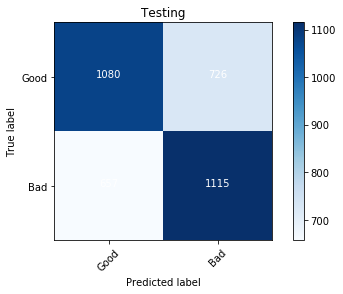

In [33]:
# Testing
y_pred = clf2.predict(Xtest1)
print('Accuracy = {}'.format(clf2.score(Xtest1, ytest)))
cm = confusion_matrix(ytest, y_pred)
plot_confusion_matrix(cm, title='Testing')